# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '/media/data/home/ypashchenko/caffe_ssd/'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

task_name = 'test_people'
image_size = 300
iter = 1000

* Load LabelMap.

In [51]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/{}/labelmap.prototxt'.format(task_name)
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

#assign names to labels
def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [63]:
model_def = 'models/{}/SSD_{}x{}/deploy.prototxt'.format(task_name, image_size, image_size)
model_weights = 'models/{}/SSD_{}x{}/VGG_{}_SSD_{}x{}_iter_{}.caffemodel'.format(task_name, image_size, image_size, task_name, image_size, image_size, iter)

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [53]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 300, 300)),
 ('data_input_0_split_0', (1, 3, 300, 300)),
 ('data_input_0_split_1', (1, 3, 300, 300)),
 ('data_input_0_split_2', (1, 3, 300, 300)),
 ('data_input_0_split_3', (1, 3, 300, 300)),
 ('data_input_0_split_4', (1, 3, 300, 300)),
 ('data_input_0_split_5', (1, 3, 300, 300)),
 ('data_input_0_split_6', (1, 3, 300, 300)),
 ('conv1_1', (1, 64, 300, 300)),
 ('conv1_2', (1, 64, 300, 300)),
 ('pool1', (1, 64, 150, 150)),
 ('conv2_1', (1, 128, 150, 150)),
 ('conv2_2', (1, 128, 150, 150)),
 ('pool2', (1, 128, 75, 75)),
 ('conv3_1', (1, 256, 75, 75)),
 ('conv3_2', (1, 256, 75, 75)),
 ('conv3_3', (1, 256, 75, 75)),
 ('pool3', (1, 256, 38, 38)),
 ('conv4_1', (1, 512, 38, 38)),
 ('conv4_2', (1, 512, 38, 38)),
 ('conv4_3', (1, 512, 38, 38)),
 ('conv4_3_relu4_3_0_split_0', (1, 512, 38, 38)),
 ('conv4_3_relu4_3_0_split_1', (1, 512, 38, 38)),
 ('pool4', (1, 512, 19, 19)),
 ('conv5_1', (1, 512, 19, 19)),
 ('conv5_2', (1, 512, 19, 19)),
 ('conv5_3', (1, 512, 19, 19)),
 ('pool5', (1

### 2. SSD detection

* Load an image.

300


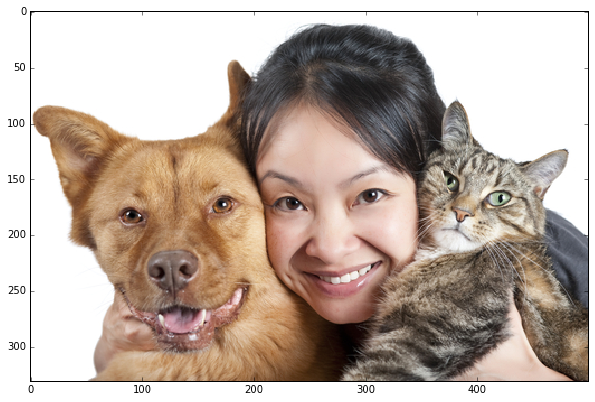

In [54]:
# set net to batch size of 1

print net.blobs['data'].data.shape[-1]
net.blobs['data'].reshape(1,3,image_size,image_size)

image = caffe.io.load_image("https://storage.googleapis.com/tcg-content/crimewire/2013/12/shutterstock_36654955.jpg")
#image = cv2.imread("/home/ypashchenko/caffe_ssd/people-005.jpg")
#image = caffe.io.load_image("/home/ypashchenko/caffe_ssd/2012.happy-people.jpg")
#print image
plt.imshow(image)

* Run the net and examine the top_k results

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(1, 1, 200, 7)
[0, 1, 2, 3, 19]
[1.0, 1.0, 1.0, 1.0, 2.0]


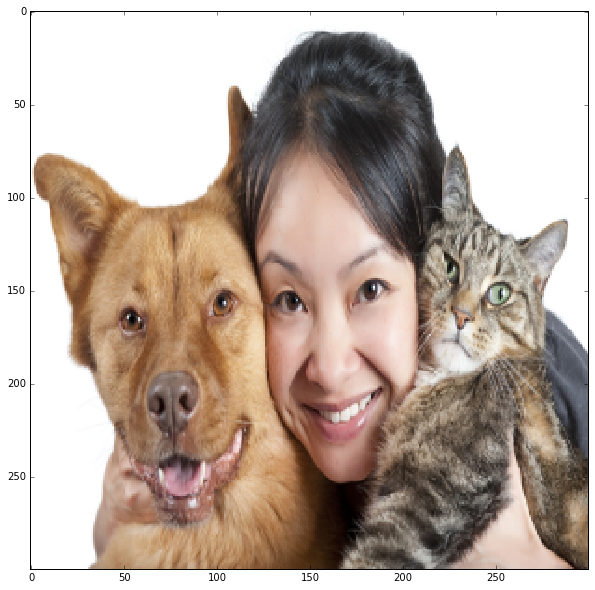

In [56]:
transformed_image = transformer.preprocess('data', image)

net.blobs['data'].data[...] = transformed_image
image_recovered = transformer.deprocess('data', net.blobs['data'].data[0])
plt.imshow(image_recovered)
# Forward pass.
detections = net.forward()['detection_out']
# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]
print detections.shape

# Get detections with confidence higher than 0.3.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.1]

print top_indices

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
print top_label_indices
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

In [57]:
print detections.shape

(1, 1, 200, 7)


* Plot the boxes

((70, 53), 375, 279)
((219, 104), 255, 216)
((14, 82), 237, 247)
((251, 203), 205, 126)
((72, 17), 356, 305)


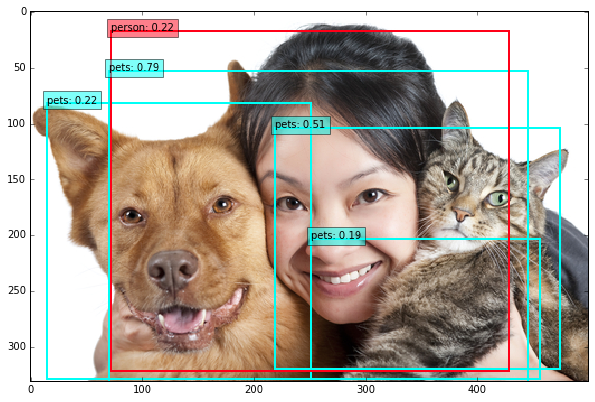

In [59]:
colors = plt.cm.hsv(np.linspace(0, 1, len(labelmap.item))).tolist()

plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    print coords 
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

#plt.savefig('/home/ypashchenko/cat.jpg')

# Lets define function for instantaneous prediction


In [60]:
def detect_objects(url, threshold):
    image = caffe.io.load_image(url)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)

    # Forward pass.
    detections = net.forward()['detection_out']
    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]
    print detections.shape

    # Get detections with confidence higher than 0.3.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= threshold]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    plt.figure()
    plt.imshow(image)
    currentAxis = plt.gca()

    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1 
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    

Lets try it!


(1, 1, 172, 7)
(1, 1, 200, 7)
(1, 1, 163, 7)


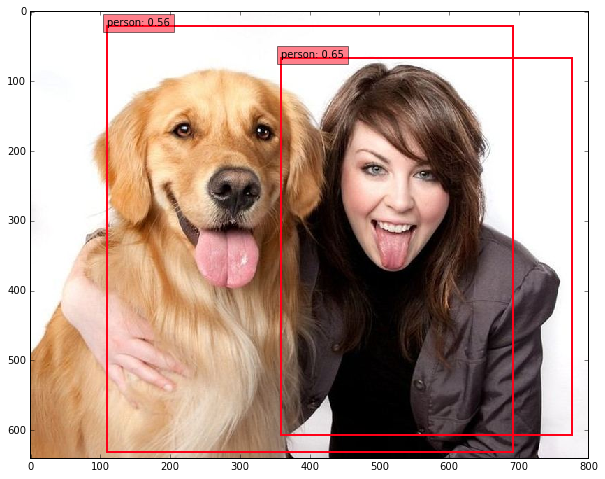

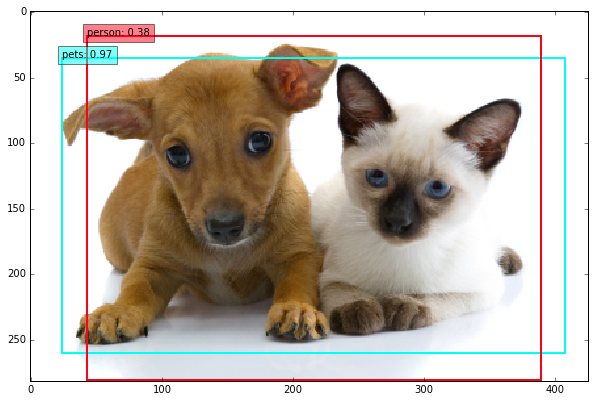

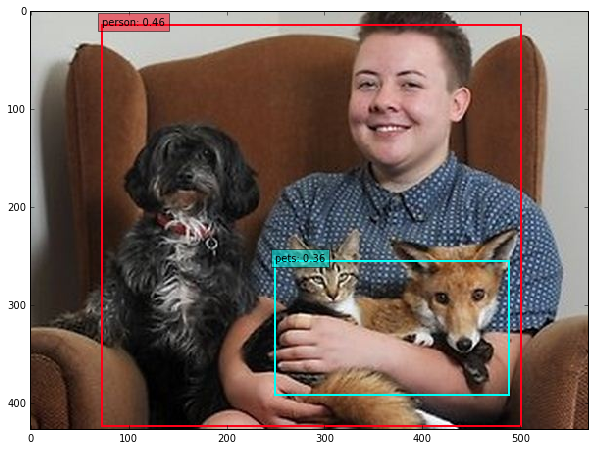

In [64]:
thr = 0.3
detect_objects('http://animalworld.com.ua/images/2011/October/Foto/Karli/Karli_4.jpg', thr)
detect_objects('http://www.peopleforpets.com/images/adoptus.jpg', thr)
detect_objects('http://www.barnorama.com/wp-content/images/2012/03/foxes-people-keep-pets/04-foxes-people-keep-pets.jpg', thr)